In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.constants as spc
import pandas as pd
from numba import jit
from scipy import interpolate

'''
Need to move this to a .py script later on!
'''

'\nNeed to move this to a .py script later on!\n'

In [2]:
'''
Pressure and Temperatures
'''

pressure_profile = np.loadtxt('pressure_profile_values.csv', delimiter=',')
pressure_altitude = pressure_profile[:, 1]
pressure = pressure_profile[:, 0]
pressure_fcn = interpolate.interp1d(pressure_altitude, pressure)

temperature_profile = np.loadtxt('temperature_profile_values.csv', delimiter=',')
temperature_altitude = temperature_profile[:, 1]
temperature = temperature_profile[:, 0]
temperature_fcn = interpolate.interp1d(temperature_altitude, temperature)

'''
Finding the mean pressure and temerature for every 5km
'''

altitude_range = np.arange(2, 99, 5)
mean_of_pressure, mean_of_temperature = ([]), ([])
for val in altitude_range:
    if val == 97:
        mean_range = np.linspace(val, 99, 10)
    else:
        mean_range = np.linspace(val, val+5, 10)
    pressure_mean = pressure_fcn(mean_range).mean()
    temperature_mean = temperature_fcn(mean_range).mean()
    mean_of_pressure = np.append(mean_of_pressure, pressure_mean)
    mean_of_temperature = np.append(mean_of_temperature, temperature_mean)

In [8]:
'''
loading datafiles
'''

class spectrum_line(object):

    def __init__(self):
        print('Reading the excel file.')
        self.excel_file = pd.read_excel("Venus Atmosphere.xlsx")

    def getParams(self, text_file):
        f = np.loadtxt(text_file, delimiter=',')
        molecule_id = f[:, 0]
        print('I am molecule ID is '+str(molecule_id[0])+ ' taken from HITRAN database')
        
        isotopologue_id = f[:, 1]
        print('My isotopologue ID is '+str(isotopologue_id[0])+ ' taken from HITRAN database')
        
        v_center = f[:, 2]
        S_0 = f[:, 3]
        delta_air = f[:, 4]
        alphaLorentz_a = f[:, 5]
        alphaDoppler_s = f[:, 6]
        gamma = f[:, 7]
        E_l = f[:, 8]
        
        return molecule_id, v_center, S_0, delta_air, alphaLorentz_a, alphaDoppler_s, gamma, E_l
    
    def setParams(self, molecule_id, v_center, S_0, delta_air, alphaLorentz_a, alphaDoppler_s, gamma, E_l):
        
        self.v_center = v_center
        self.S_0 = S_0
        self.delta_air = delta_air
        self.alphaLorentz_a = alphaLorentz_a
        self.alphaDoppler_s = alphaDoppler_s
        self.gamma = gamma
        self.E_l = E_l
        
        if molecule_id == 5.0:
            molecule = self.excel_file.CO
        if molecule_id == 22.0:
            molecule = self.excel_file.N2
        if molecule_id == 9.0:
            molecule = self.excel_file.SO2
        if molecule_id == 1.0:
            molecule = self.excel_file.H2O
        if molecule_id == 2.0:
            molecule = self.excel_file.CO2
   
        self.q = molecule[0]
        self.m = molecule[1]
        self.coeff1_L = molecule[2] 
        self.coeff2_L = molecule[3]
        self.coeff3_L = molecule[4]
        self.coeff4_L = molecule[5]
        self.coeff1_M = molecule[6] 
        self.coeff2_M = molecule[7]
        self.coeff3_M = molecule[8]
        self.coeff4_M = molecule[9]
        
    def setLayersParams(self, pressure, temperature):
        self.pressure = pressure
        self.temperature = temperature
        self.path_length = 5 #[km] this is fixed parameter
        
    def doppler_broadening(self):
        '''
        For pressures less than 0.1 atm, altitudes below 16 km
        '''
        T = self.temperature
        v_center = self.v_center
        m = self.m
        sqrt = np.sqrt(2*spc.k*T/(m*spc.c**2))
        alpha_doppler = v_center*sqrt
        return alpha_doppler 
    
    def lorentz_broadening(self):
        P, T = self.pressure, self.temperature
        P_0, T_0 = 1, 296                         #[atm, K]
        alphaLorentz_a = self.alphaLorentz_a
        alphaLorentz_s = self.alphaDoppler_s
        q = self.q
        gamma = self.gamma 
        pressureRatio = P/P_0
        tempRatio = T_0/T
        alpha_lorentz = ((1-q)*alphaLorentz_a+q*alphaLorentz_s)*pressureRatio*tempRatio**gamma
        return alpha_lorentz
    
    def voigt_profile_substitute(self,v):
        v_c = self.v_center
        if self.pressure > 0.1:
            alpha = self.lorentz_broadening()
            a = ((v - v_c)/alpha)**2
            f = 1/(np.pi*alpha*(1+a))
            return f
        else:
            alpha = self.doppler_broadening()
            sigma = alpha*2/2.355
            a = ((v - v_c)/4*sigma)**2
            f = np.exp(-a)/(sigma*np.sqrt(2*np.pi))
            return f
    
    def line_shape(self, v):
        T = self.temperature
        v_center = self.v_center 
        f = self.voigt_profile_substitute(v)
        tanh = np.tanh(spc.h*spc.c*v/(2*spc.k*T))
        tanh_center = np.tanh(spc.h*spc.c * v_center/(2*spc.k*T))
        g = v * tanh * f/(v_center*tanh_center)
        return g
    
    def total_internal_partition(self, temperature):
        '''
        Valid only for temeratures between 70-1500K
        '''
        T = temperature
        
        if T >= 70 and T <= 500:
            a, b, c, d = self.coeff1_L, self.coeff2_L, self.coeff3_L, self.coeff4_L
            Q = a + b*T + c*T**2 + d*T**3
            return Q
        
        if T > 500 and T <= 1500:
            a, b, c, d = self.coeff1_M, self.coeff2_M, self.coeff3_M, self.coeff4_M
            Q = a + b*T + c*T**2 + d*T**3
            return Q
            
                
    def line_intensity(self):
        T = self.temperature
        v_center = self.v_center
        S_0, T_0 = self.S_0, 296
        Q_T = self.total_internal_partition(T)
        Q_T0 = self.total_internal_partition(296)
        E_l = self.E_l
        exp_lower = np.exp(spc.h*spc.c*E_l/(spc.k*T))
        exp_lower0 = np.exp(spc.h*spc.c*E_l/(spc.k*T_0))
        exp_center = np.exp(spc.h*spc.c*v_center/(spc.k*T))
        exp_center0 = np.exp(spc.h*spc.c*v_center/(spc.k*T))
        S = S_0*Q_T0*exp_lower*exp_center/(Q_T*exp_lower0*exp_center0)
        return S
        
    def transmittance(self, v):
        P = self.pressure
        T = self.temperature
        x = self.path_length
        q = self.q
        g = self.line_shape(v)
        S = self.line_intensity()
        numerator = -q*P*x*S*g
        denominator = spc.Boltzmann * T
        tau = np.exp(numerator/denominator)
        return tau


In [9]:
a = spectrum_line()

Reading the excel file.


In [10]:
molecule_id, v_center, S_0, delta_air, alphaLorentz_a, alphaDoppler_s, gamma, E_l = a.getParams('CO.txt')

I am molecule ID is 5.0 taken from HITRAN database
My isotopologue ID is 1.0 taken from HITRAN database


In [11]:
tau_aggregate = ([])
wavenumbers = ([])

i = 0
for center in v_center:
    a.setParams(molecule_id[i], v_center[i], S_0[i], delta_air[i], alphaLorentz_a[i], alphaDoppler_s[i], gamma[i], E_l[i])
    v = np.linspace(center-0.01, center+0.01, 5)
    wavenumbers = np.append(wavenumbers, v)
    for wavenumber in v:
        tau = 1
        for j in range(0, len(mean_of_pressure)):
            a.setLayersParams(mean_of_pressure[j], mean_of_temperature[j])
            tau = a.transmittance(wavenumber)*tau
        tau_aggregate = np.append(tau_aggregate, tau)
    print(i)   
    i = i+1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<ipython-input-13-cf769067c059>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(wavenumbers, np.log(1/tau_aggregate))
<ipython-input-13-cf769067c059>:2: RuntimeWarning: overflow encountered in true_divide
  plt.plot(wavenumbers, np.log(1/tau_aggregate))


<IPython.core.display.Javascript object>


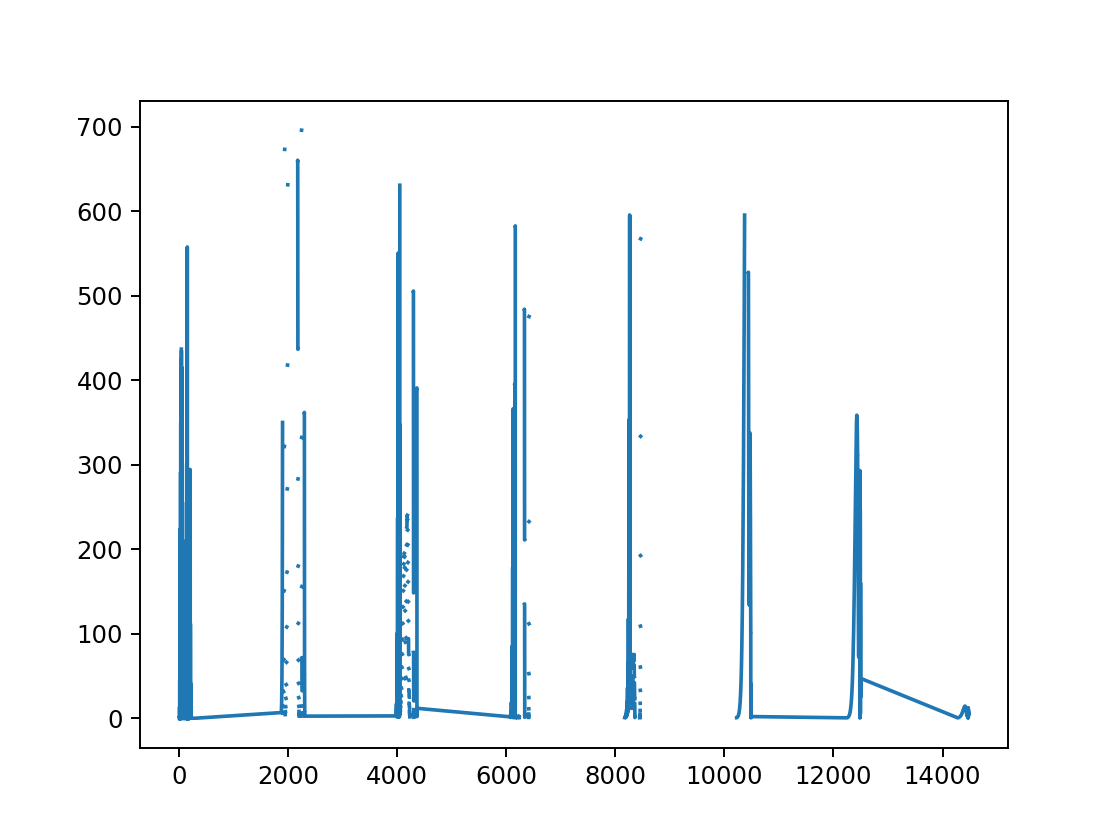

In [13]:
%matplotlib notebook
plt.plot(wavenumbers, np.log(1/tau_aggregate))

In [23]:
a = spectrum_singleGas()

Reading the excel file.


In [28]:
a.setParams('N2.txt')

I am molecule ID 22.0 from HITRAN database
My isotopologue ID 1.0 from HITRAN database


In [17]:
v_center, S_0, delta_ait, alphaLorentz_a, alphaDoppler_s, gamma, E_l = get_params('CO.txt')

I am molecule ID 5.0 from HITRAN database
My isotopologue ID 1.0 from HITRAN database, that means I am the most abundant topologue


In [ ]:
'''
Pressure profile numbers
'''
0.03114759459223761, 99.88052581859645
0.04262541256340627, 98.93404132848241
0.07396330468192495, 96.72792770958246
0.11301339760002972, 95.15173882029576
0.24864588317020964, 92.209556282034
0.3930284488717709, 90.4235026480965
0.5954637653326739, 88.74271188214527
0.9654835333099134, 86.53747958500763
1.984897261790517, 83.17733020096892
2.981859058125867, 81.39193755835316
4.404246790234677, 79.71147728806278
7.707288763992225, 76.87698125263366
12.286455656692105, 74.46254520216698
20.09085512084656, 71.94306661415459
34.861505127091675, 68.89925666017612
57.980570316010635, 66.17013365795353
97.25257399727431, 63.33618844862584
143.6433877390448, 61.23688001079621
219.48217918303857, 58.92770682831578
387.3570995946821, 55.98838858578154
655.2581246199782, 52.63077300180948
1053.4639388558178, 49.273818409159155
1812.5296226833775, 45.39242228532242
2566.0096489281436, 42.77010446417015
3790.031500384198, 39.3095394818379
6632.431966086814, 33.85724239928835
10220.419000618213, 29.453718213891293
16431.452663623844, 23.688386657890177
21921.649246600668, 20.54327978385585
29999.727280369407, 16.560146079082116
39685.54042726621, 12.472740993304711
62729.96036732756, 6.184069558320104
91095.097001193, 0.10592385930800674

In [ ]:
'''
Temperature Profiles
'''

166.07142857142856, 99.79035639412999
173.6344537815126, 94.33962264150945
181.19747899159665, 90.04192872117402
191.5966386554622, 85.95387840670861
201.99579831932772, 83.12368972746333
216.17647058823528, 79.45492662473796
230.35714285714283, 77.04402515723271
236.34453781512605, 75.36687631027254
238.8655462184874, 74.42348008385746
240.75630252100837, 72.8511530398323
242.96218487394958, 70.44025157232706
244.22268907563023, 67.9245283018868
242.33193277310926, 66.03773584905662
244.8529411764706, 63.94129979035641
247.3739495798319, 62.8930817610063
248.94957983193274, 61.94968553459121
245.16806722689074, 60.69182389937108
240.44117647058823, 59.433962264150956
239.18067226890756, 58.595387840670874
240.12605042016804, 57.75681341719079
242.96218487394958, 57.65199161425578
246.74369747899158, 57.12788259958072
249.89495798319325, 56.813417190775695
299.0546218487395, 52.201257861635234
322.37394957983196, 49.68553459119499
353.57142857142856, 45.91194968553461
404.30672268907557, 40.25157232704403
436.13445378151255, 36.68763102725369
468.90756302521004, 32.9140461215933
504.516806722689, 29.035639412997924
536.6596638655462, 25.262054507337538
559.9789915966386, 22.641509433962284
599.6848739495798, 17.610062893081775
627.4159663865546, 14.150943396226424
648.844537815126, 11.320754716981142
681.9327731092437, 6.708595387840688
725.7352941176471, 1.257861635220138
733.9285714285713, 0

In [6]:
f = np.loadtxt('/Users/akank/Downloads/CO.txt', delimiter=',')
#print(f.read())
#f.close()

In [7]:
f.shape

(1344, 9)

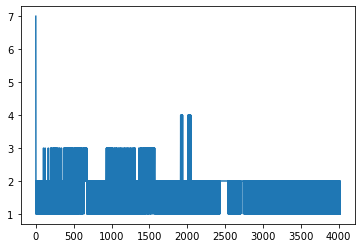

In [25]:
x = []
for y in f.read().split(','):
    print(y)
    if y.isdigit():
        x.append(float(y))

plt.plot(x)

In [4]:
'''
Conventions 

v = wavenumber[cm^-1] --- number if waves per cm. v = f/c
tau = transmittance --- ratio of transmitted radiance to incident radiance
epsilon = emissivity --- ratio of emitted radiance at v to the radiance emitted by the black body at the same temperature
alpha = absorptivity --- fraction of incident radiance at v that is absorbed
g = line shape
f = voigt profile
S = line intesity
alpha_doppler =
alpha_lorentz = 
v_center = 
E_l = 
T_0 = 296K
P_0 = 1atm

'''

'''
Parameters

v = give a list of values to calculate(spectral range)

'''

'\nConventions \n\nv = wavenumber[cm^-1] --- number if waves per cm. v = f/c\ntau = transmittance --- ratio of transmitted radiance to incident radiance\nepsilon = emissivity --- ratio of emitted radiance at v to the radiance emitted by the black body at the same temperature\nalpha = absorptivity --- fraction of incident radiance at v that is absorbed\n\n'

In [9]:
def wavenumber_center(pressure):
    P_0 = 1 #[atm] 
    pressureRatio = pressure/P_0
    #delta = 
    #v_0 =
    v_center = v_0 + delta*pressureRatio
    return v_center

def doppler_broadening(temperature):
    '''
    For pressures less than 0.1 atm, altitudes below 16 km
    '''
    T = temperature
    v_center = wavenumber_center(pressure) 
    #m = 
    sqrt = np.sqrt(2*spc.k*T/(m*spc.c**2))
    alpha_doppler = v_center*sqrt
    return alpha_doppler
    
def lorentz_broadening(pressure, temperature):
    P, T = pressure, temperature
    P_0 = 1 #[atm] unsure
    T_0 = 296 #[K]
    #alphaLorentz_a = 
    #alphaLorentz_s = 
    #q = 
    #gamma = 
    pressureRatio = P/P_0
    tempRatio = T_0/T
    alpha_lorentz = ((1-q)*alphaLorentz_a+q*alphaLorentz_s)*pressureRatio*tempRatio**gamma
    return alpha_lorentz

def integral_func(t, a, b):
    val = np.exp(-t**2)/((a - t)**2 + b**2)
    return val
    
def voigt_profile():
    alpha_doppler = doppler_broadening(pressure, temperature)
    alpha_lorentz = lorentz_broadening(temperature)
    #v = 
    v_center = wavenumber_center(pressure)  
    a = (v - v_center)/alpha_doppler
    b = alpha_lorentz/alpha_doppler
    integral = quad(integral_func, -np.inf, np.inf, )
    f = b*integral /(alpha_doppler*np.sqrt(np.pi)*np.pi)
    return f

def line_shape():
    #v =
    v_center = wavenumber_center(pressure)  
    f = voigt_profile()
    tanh = np.tanh(spc.h*spc.c*v/(2*spc.k*T))
    tanh_center = np.tanh(spc.h*spc.c * v_center/(2*spc.k*T))
    g = v * tanh * f/(v_center*tanh_center)
    return g

def line_shape(pressure):
    if pressure > 0.1:
        alpha = lorentz_broadening(pressure, temperature)
        a = ((v - v_c)/alpha)**2
        f = 1/(np.pi*alpha*(1+a))
        return f
    else:
        alpha = doppler_broadening(temperature)
        sigma = alpha*2/2.355
        a = ((v - v_c)/4*sigma)**2
        f = np.exp(-a)/(sigma*np.sqrt(2*np.pi))
        return f
    
def line_intensity(temperature):
    T = temperature
    v_center = wavenumber_center(pressure)
    #S_0, T_0 = ,296
    #Q_v, Q_r = 
    #Q_v0, Q_r0 =
    #E_l = 
    exp_lower = np.exp(spc.h*spc.c*E_l/(spc.k*T))
    exp_lower0 = np.exp(spc.h*spc.c*E_l/(spc.k*T_0))
    exp_center = np.exp(spc.h*spc.c*v_center/(spc.k*T))
    exp_center0 = np.exp(spc.h*spc.c*v_center/(spc.k*T))
    S = S_0*Q_v0*Q_r0*exp_lower*exp_center/(Q_v*Q_r*exp_lower0*exp_center0)
    return S
    
def transmittance(pressure, temperature):
    P = pressure
    T = temperature
    #x = 
    #q = 
    g = line_shape()
    S = line_intensity(temperature)
    numerator = -q*P*x*S*g
    denominator = spc.Boltzmann * T
    tau = np.exp(numerator/denominator)
    return tau